In [1]:
from glob import glob
from path import Path
from os import listdir, stat
from shutil import copyfile
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np

# Analyzing dataset

In [2]:
def init_fig(height=15, width=15):
    fig = plt.figure()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    return fig

In [3]:
SCRAPER_FOLDER = Path('/home/jossalgon/Documentos/Master/scraper/')
CSV_FOLDER = Path('/home/jossalgon/Documentos/Master/Notebooks/csv/')

DATA_PATH = Path(SCRAPER_FOLDER/'inaturalist/inaturalist.csv')
CSV_PATH = Path(SCRAPER_FOLDER/'families_3.csv')
ALL_CSV_PATH = Path(SCRAPER_FOLDER/'species1000.csv')

CLEAN_CSV_PATH = Path(CSV_FOLDER/'species1000-df-filtered.csv')
CLEAN_SAMPLE_CSV_PATH = Path(CSV_FOLDER/'families_3.csv')
STRATIFIED_CSV_PATH = Path(CSV_FOLDER/'species1000-stratified.csv')
STRATIFIED_SAMPLE_CSV_PATH = Path(CSV_FOLDER/'families3-stratified.csv')
WEIGHTS_CSV_PATH = Path(CSV_FOLDER/'species1000-weights.csv')
WEIGHTS_SAMPLE_CSV_PATH = Path(CSV_FOLDER/'families3-weights.csv')
WEIGHTS_FAMILIES_CSV_PATH = Path(CSV_FOLDER/'species1000-weights-family.csv')
WEIGHTS_SAMPLE_FAMILIES_CSV_PATH = Path(CSV_FOLDER/'families3-weights-family.csv')
WEIGHTS_GENUS_CSV_PATH = Path(CSV_FOLDER/'species1000-weights-genus.csv')
WEIGHTS_SAMPLE_GENUS_CSV_PATH = Path(CSV_FOLDER/'families3-weights-genus.csv')
WEIGHTS_ORDER_CSV_PATH = Path(CSV_FOLDER/'species1000-weights-order.csv')
WEIGHTS_SAMPLE_ORDER_CSV_PATH = Path(CSV_FOLDER/'families3-weights-order.csv')

In [4]:
df = pd.read_csv(DATA_PATH)
df.head()

,Order,Family,Subfamily,Genus,Specie,Observations,url
0,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser baerii,4,https://www.inaturalist.org/taxa/93179-Acipens...
1,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser brevirostrum,11,https://www.inaturalist.org/taxa/49823-Acipens...
2,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser dabryanus,0,https://www.inaturalist.org/taxa/93180-Acipens...
3,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser fulvescens,380,https://www.inaturalist.org/taxa/93181-Acipens...
4,Acipenseriformes,Acipenseridae,Acipenserinae,Acipenser,Acipenser gueldenstaedtii,7,https://www.inaturalist.org/taxa/93182-Acipens...


In [5]:
def asc_group_by(df, key):
    return df.groupby([key]).sum().sort_values(by=['Observations'], ascending=False)

In [6]:
orders = asc_group_by(df, 'Order')
print('Size:', orders.size)
orders

Size: 46


,Observations
Order,
Perciformes,275755
Cypriniformes,43970
Tetraodontiformes,31372
Scorpaeniformes,21186
Salmoniformes,14681
Syngnathiformes,14595
Cyprinodontiformes,14095
Anguilliformes,11023
Siluriformes,10999


In [7]:
families = asc_group_by(df, 'Family')
print('Size:', families.size)
families.head(10)

Size: 490


,Observations
Family,
Centrarchidae,39237
Cyprinidae,38766
Pomacentridae,26312
Labridae,19882
Chaetodontidae,15153
Salmonidae,14681
Serranidae,14195
Gobiidae,13500
Acanthuridae,12559


In [8]:
subfamilies = asc_group_by(df, 'Subfamily')
print('Size:', subfamilies.size)
subfamilies.head(10)

Size: 302


,Observations
Subfamily,
Pomacentrinae,22178
Leuciscinae,20404
Salmoninae,14108
Corinae,14002
Cyprininae,12769
Gobiinae,10255
Acanthurinae,9645
Poeciliinae,8641
Epinephelinae,8188


In [9]:
genera = asc_group_by(df, 'Genus')
print('Size:', genera.size)
genera.head(10)

Size: 4511


,Observations
Genus,
Lepomis,22046
Micropterus,12970
Chaetodon,11725
Cyprinus,8812
Oncorhynchus,7957
Acanthurus,6824
Hippocampus,6503
Lutjanus,5873
Gambusia,5697


In [10]:
species = asc_group_by(df, 'Specie')
print('Size:', species.size)
species.head(10)

Size: 30712


,Observations
Specie,
Lepomis macrochirus,9119
Micropterus salmoides,8615
Cyprinus carpio,5299
Oncorhynchus mykiss,4199
Gambusia affinis,3790
Cyprinus rubrofuscus,3511
Lepomis cyanellus,3375
Carassius auratus,3033
Lepomis gibbosus,2969


In [11]:
df_1000 = df.sort_values(by=['Observations'], ascending=False)[:1000]
df_1000

,Order,Family,Subfamily,Genus,Specie,Observations,url
13670,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis macrochirus,9119,https://www.inaturalist.org/taxa/49591-Lepomis...
13688,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,8615,https://www.inaturalist.org/taxa/49587-Micropt...
5433,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus carpio,5299,https://www.inaturalist.org/taxa/53911-Cyprinu...
23808,Salmoniformes,Salmonidae,Salmoninae,Oncorhynchus,Oncorhynchus mykiss,4199,https://www.inaturalist.org/taxa/47516-Oncorhy...
8806,Cyprinodontiformes,Poeciliidae,Poeciliinae,Gambusia,Gambusia affinis,3790,https://www.inaturalist.org/taxa/59115-Gambusi...
...,...,...,...,...,...,...,...
24336,Scorpaeniformes,Cyclopteridae,NaN,Cyclopterus,Cyclopterus lumpus,107,https://www.inaturalist.org/taxa/60603-Cyclopt...
21655,Perciformes,Serranidae,Epinephelinae,Cephalopholis,Cephalopholis cyanostigma,107,https://www.inaturalist.org/taxa/96992-Cephalo...
4911,Cypriniformes,Cyprinidae,Barbinae,Barbus,Barbus barbus,107,https://www.inaturalist.org/taxa/95147-Barbus-...
10388,Gobiesociformes,Gobiesocidae,Gobiesocinae,Trachelochismus,Trachelochismus pinnulatus,107,https://www.inaturalist.org/taxa/474797-Trache...


In [12]:
df_1000.describe(include='all')

,Order,Family,Subfamily,Genus,Specie,Observations,url
count,1000,1000,632,1000,1000,1000.000000,1000
unique,29,135,101,454,1000,NaN,1000
top,Perciformes,Pomacentridae,Pomacentrinae,Chaetodon,Hemitaurichthys polylepis,NaN,https://www.inaturalist.org/taxa/52956-Chaetod...
freq,609,67,57,33,1,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,362.427000,NaN
std,NaN,NaN,NaN,NaN,NaN,565.202911,NaN
min,NaN,NaN,NaN,NaN,NaN,107.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,149.750000,NaN
50%,NaN,NaN,NaN,NaN,NaN,225.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,395.500000,NaN


In [13]:
limit = 3
selected_families = list(families[:limit].index)
selected_families

['Centrarchidae', 'Cyprinidae', 'Pomacentridae']

In [14]:
df_selected = df_1000[df_1000['Family'].isin(selected_families)]
df_selected

,Order,Family,Subfamily,Genus,Specie,Observations,url
13670,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis macrochirus,9119,https://www.inaturalist.org/taxa/49591-Lepomis...
13688,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,8615,https://www.inaturalist.org/taxa/49587-Micropt...
5433,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus carpio,5299,https://www.inaturalist.org/taxa/53911-Cyprinu...
5452,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus rubrofuscus,3511,https://www.inaturalist.org/taxa/187316-Cyprin...
13666,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis cyanellus,3375,https://www.inaturalist.org/taxa/58636-Lepomis...
...,...,...,...,...,...,...,...
20574,Perciformes,Pomacentridae,Pomacentrinae,Chrysiptera,Chrysiptera taupou,111,https://www.inaturalist.org/taxa/181017-Chrysi...
20759,Perciformes,Pomacentridae,Pomacentrinae,Stegastes,Stegastes marginatus,111,https://www.inaturalist.org/taxa/154336-Stegas...
20720,Perciformes,Pomacentridae,Pomacentrinae,Pomacentrus,Pomacentrus sulfureus,108,https://www.inaturalist.org/taxa/119310-Pomace...
20428,Perciformes,Pomacentridae,Pomacentrinae,Amblyglyphidodon,Amblyglyphidodon leucogaster,108,https://www.inaturalist.org/taxa/181015-Amblyg...


In [15]:
df_selected.describe(include='all')

,Order,Family,Subfamily,Genus,Specie,Observations,url
count,144,144,121,144,144,144.000000,144
unique,2,3,11,56,144,NaN,144
top,Perciformes,Pomacentridae,Pomacentrinae,Lepomis,Rhinichthys cataractae,NaN,https://www.inaturalist.org/taxa/48558-Plectro...
freq,90,67,57,12,1,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,621.333333,NaN
std,NaN,NaN,NaN,NaN,NaN,1229.371304,NaN
min,NaN,NaN,NaN,NaN,NaN,107.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,161.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,268.500000,NaN
75%,NaN,NaN,NaN,NaN,NaN,478.250000,NaN


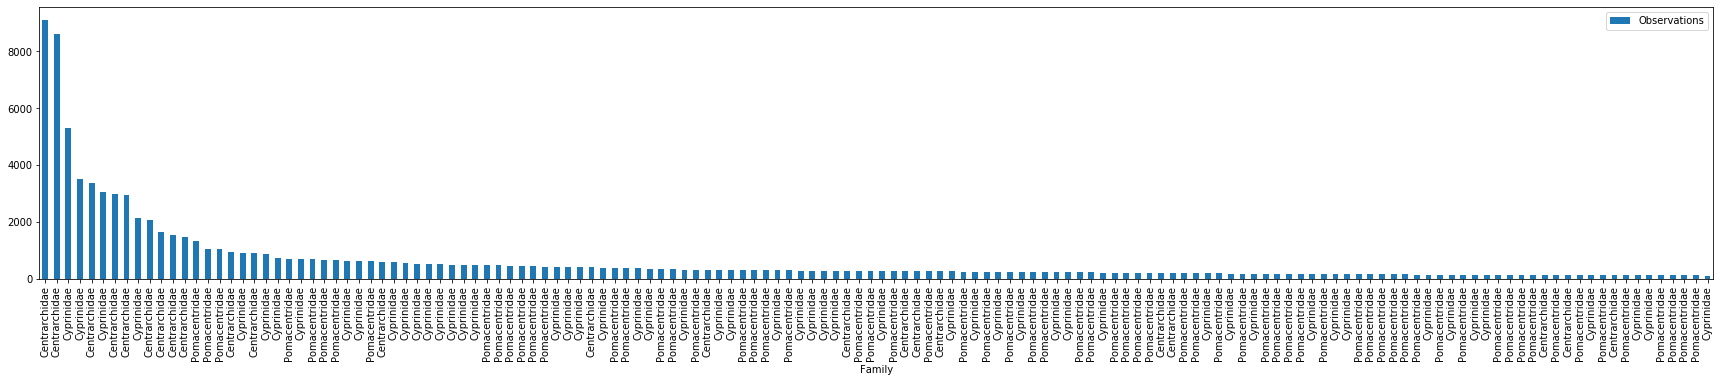

In [16]:
df_selected.plot(x='Family', y='Observations', kind='bar', figsize=(30,5))

In [17]:
df_selected.describe(include = 'object')

,Order,Family,Subfamily,Genus,Specie,url
count,144,144,121,144,144,144
unique,2,3,11,56,144,144
top,Perciformes,Pomacentridae,Pomacentrinae,Lepomis,Rhinichthys cataractae,https://www.inaturalist.org/taxa/48558-Plectro...
freq,90,67,57,12,1,1


In [18]:
def count_nulls(df, column):
    return df[column].isnull().sum()

In [19]:
print(f"Order contains {count_nulls(df_selected, 'Order')} nan values.")
print(f"Family contains {count_nulls(df_selected, 'Family')} nan values.")
print(f"Subfamily contains {count_nulls(df_selected, 'Subfamily')} nan values.")
print(f"Genus contains {count_nulls(df_selected, 'Genus')} nan values.")
print(f"Specie contains {count_nulls(df_selected, 'Specie')} nan values.")

Order contains 0 nan values.
Family contains 0 nan values.
Subfamily contains 23 nan values.
Genus contains 0 nan values.
Specie contains 0 nan values.


In [20]:
df_nan_selected = df_selected[df_selected['Subfamily'].isnull()]
df_nan_selected

,Order,Family,Subfamily,Genus,Specie,Observations,url
13670,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis macrochirus,9119,https://www.inaturalist.org/taxa/49591-Lepomis...
13688,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,8615,https://www.inaturalist.org/taxa/49587-Micropt...
13666,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis cyanellus,3375,https://www.inaturalist.org/taxa/58636-Lepomis...
13667,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gibbosus,2969,https://www.inaturalist.org/taxa/49614-Lepomis...
13682,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus dolomieu,2933,https://www.inaturalist.org/taxa/49590-Micropt...
13672,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis megalotis,2045,https://www.inaturalist.org/taxa/58635-Lepomis...
13665,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis auritus,1628,https://www.inaturalist.org/taxa/85365-Lepomis...
13693,Perciformes,Centrarchidae,NaN,Pomoxis,Pomoxis nigromaculatus,1521,https://www.inaturalist.org/taxa/49594-Pomoxis...
13659,Perciformes,Centrarchidae,NaN,Ambloplites,Ambloplites rupestris,1475,https://www.inaturalist.org/taxa/58637-Amblopl...
13668,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gulosus,922,https://www.inaturalist.org/taxa/104252-Lepomi...


In [21]:
# df_selected.to_csv(CSV_PATH, index=False)

In [22]:
# df_1000.to_csv(ALL_CSV_PATH, index=False)

# Cleaning dataset

In [ ]:
# from fastai.vision.all import *

# df_path = Path('/root/Documents/')
# df = pd.read_csv(df_path/"species1000-df.csv")
# path = Path('/root/Documents/images')
# fns = get_image_files(path)
# failed = verify_images(fns)
# failed2 = [str(f).replace(str(path)+'/', '') for f in failed]
# filtered_df = df[~df['fname'].isin(failed2)]
# filtered_df.to_csv(df_path/'species1000-df-filtered.csv', index=False)

# Handling Class Imbalance

## 1000 Species (Full dataset)

In [96]:
df_images_1000 = pd.read_csv(CLEAN_CSV_PATH)

In [97]:
train, test, _, _ = train_test_split(df_images_1000, df_images_1000['Specie'],
                                                    stratify=df_images_1000['Specie'], 
                                                    test_size=0.2, random_state=42)

In [98]:
train['is_valid'] = False
test['is_valid'] = True

/home/jossalgon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jossalgon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
df_1000_stratified = pd.concat([train, test])

In [107]:
df_1000_stratified.to_csv(STRATIFIED_CSV_PATH, index=False)

In [21]:
df_1000_stratified = pd.read_csv(STRATIFIED_CSV_PATH)

In [22]:
df_1000_stratified

,Order,Family,Subfamily,Genus,Specie,fname,is_valid
0,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis gibbosus,Lepomis gibbosus/1879321.jpg,False
1,Perciformes,Centrarchidae,NaN,Pomoxis,Pomoxis nigromaculatus,Pomoxis nigromaculatus/61056925.jpg,False
2,Perciformes,Centrarchidae,NaN,Lepomis,Lepomis miniatus,Lepomis miniatus/36578909.jpg,False
3,Cypriniformes,Cyprinidae,Leuciscinae,Scardinius,Scardinius erythrophthalmus,Scardinius erythrophthalmus/77068790.jpg,False
4,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus olivaceus,Acanthurus olivaceus/14646458.jpg,False
...,...,...,...,...,...,...,...
422172,Perciformes,Acanthuridae,Acanthurinae,Acanthurus,Acanthurus coeruleus,Acanthurus coeruleus/33472582.jpg,True
422173,Perciformes,Gobiidae,Gobiinae,Amblyeleotris,Amblyeleotris steinitzi,Amblyeleotris steinitzi/3789141.jpg,True
422174,Perciformes,Percidae,Etheostomatinae,Etheostoma,Etheostoma caeruleum,Etheostoma caeruleum/40879890.jpg,True
422175,Perciformes,Kyphosidae,Microcanthinae,Tilodon,Tilodon sexfasciatus,Tilodon sexfasciatus/26825770.jpg,True


In [91]:
df_value_counts = df_1000_stratified['Specie'].value_counts()
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Especie', 'Número de imágenes']
df_value_counts.set_index('Especie').plot(backend='plotly', kind='area')

In [98]:
df_value_counts = df_1000_stratified['Order'].value_counts()
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Orden', 'Número de imágenes']
df_value_counts.set_index('Orden').plot(backend='plotly', kind='area')

In [86]:
df_value_counts = df_1000_stratified['Family'].value_counts()
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Familia', 'Número de imágenes']
df_value_counts.set_index('Familia').plot(backend='plotly', kind='area')

In [87]:
df_value_counts = df_1000_stratified['Genus'].value_counts()
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Género', 'Número de imágenes']
df_value_counts.set_index('Género').plot(backend='plotly', kind='area')

In [23]:
species_count = df_1000_stratified.groupby('Specie')['Specie'].count()
species, count_values = species_count.keys(), species_count.values
weights = compute_class_weight('balanced', classes=species, y=df_1000_stratified['Specie'])

In [104]:
weights_df = pd.DataFrame.from_dict({'Specie': species, 'Count': count_values, 'Weight': weights})
weights_df

,Specie,Count,Weight
0,Abramis brama,319,1.323439
1,Abudefduf abdominalis,221,1.910303
2,Abudefduf bengalensis,323,1.307050
3,Abudefduf saxatilis,1692,0.249514
4,Abudefduf septemfasciatus,149,2.833403
...,...,...,...
995,Zanclus cornutus,1966,0.214739
996,Zebrasoma desjardinii,166,2.543235
997,Zebrasoma flavescens,561,0.752544
998,Zebrasoma scopas,276,1.529627


In [109]:
weights_df.to_csv(WEIGHTS_CSV_PATH, index=False)

In [110]:
families_count = df_1000_stratified.groupby('Family')['Family'].count()
families, count_values = families_count.keys(), families_count.values
weights = compute_class_weight('balanced', classes=families, y=df_1000_stratified['Family'])

In [111]:
weights_df = pd.DataFrame.from_dict({'Family': families, 'Count': count_values, 'Weight': weights})
weights_df

,Family,Count,Weight
0,Acanthuridae,12587,0.248450
1,Achiridae,152,20.573928
2,Acipenseridae,300,10.424123
3,Amiidae,796,3.928690
4,Ammodytidae,271,11.539620
...,...,...,...
130,Tetrarogidae,389,8.039170
131,Trichiuridae,212,14.751118
132,Triglidae,429,7.289597
133,Umbridae,586,5.336582


In [114]:
weights_df.to_csv(WEIGHTS_FAMILIES_CSV_PATH, index=False)

In [123]:
genus_count = df_1000_stratified.groupby('Genus')['Genus'].count()
genus, count_values = genus_count.keys(), genus_count.values
weights = compute_class_weight('balanced', classes=genus, y=df_1000_stratified['Genus'])

In [124]:
weights_df = pd.DataFrame.from_dict({'Genus': genus, 'Count': count_values, 'Weight': weights})
weights_df

,Genus,Count,Weight
0,Abramis,319,2.915064
1,Abudefduf,5547,0.167641
2,Acanthaluteres,246,3.780103
3,Acanthistius,179,5.195002
4,Acanthochromis,142,6.548629
...,...,...,...
449,Variola,189,4.920134
450,Xiphister,173,5.375175
451,Xiphophorus,668,1.392074
452,Zanclus,1966,0.472994


In [125]:
weights_df.to_csv(WEIGHTS_GENUS_CSV_PATH, index=False)

In [126]:
order_count = df_1000_stratified.groupby('Order')['Order'].count()
order, count_values = order_count.keys(), order_count.values
weights = compute_class_weight('balanced', classes=order, y=df_1000_stratified['Order'])

In [127]:
weights_df = pd.DataFrame.from_dict({'Order': order, 'Count': count_values, 'Weight': weights})
weights_df

,Order,Count,Weight
0,Acipenseriformes,300,48.526092
1,Amiiformes,796,18.288728
2,Anguilliformes,10738,1.355730
3,Atheriniformes,1166,12.485272
4,Aulopiformes,1644,8.855126
5,Batrachoidiformes,1297,11.224231
6,Beloniformes,986,14.764531
7,Beryciformes,2431,5.988411
8,Characiformes,310,46.960734
9,Clupeiformes,3120,4.665970


In [128]:
weights_df.to_csv(WEIGHTS_ORDER_CSV_PATH, index=False)

## Families 3 (Sample)

In [23]:
df_images_families3 = pd.read_csv(CLEAN_SAMPLE_CSV_PATH)

In [38]:
train, test, _, _ = train_test_split(df_images_families3, df_images_families3['Specie'],
                                                    stratify=df_images_families3['Specie'], 
                                                    test_size=0.2, random_state=42)

In [39]:
train['is_valid'] = False
test['is_valid'] = True

/home/jossalgon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jossalgon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
df_families3_stratified = pd.concat([train, test])

In [41]:
df_families3_stratified.to_csv(STRATIFIED_SAMPLE_CSV_PATH, index=False)

In [24]:
df_families3_stratified = pd.read_csv(STRATIFIED_SAMPLE_CSV_PATH)

In [42]:
df_families3_stratified

,Order,Family,Subfamily,Genus,Specie,fname,is_valid
73824,Perciformes,Centrarchidae,NaN,Ambloplites,Ambloplites rupestris,Ambloplites rupestris/25240275.jpg,False
72719,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,Micropterus salmoides/65295609.jpg,False
34808,Perciformes,Centrarchidae,NaN,Micropterus,Micropterus salmoides,Micropterus salmoides/47839127.jpg,False
52192,Perciformes,Pomacentridae,Pomacentrinae,Abudefduf,Abudefduf abdominalis,Abudefduf abdominalis/14442685.jpg,False
67390,Perciformes,Pomacentridae,Pomacentrinae,Chromis,Chromis multilineata,Chromis multilineata/49300790.jpg,False
...,...,...,...,...,...,...,...
6795,Perciformes,Pomacentridae,Pomacentrinae,Mecaenichthys,Mecaenichthys immaculatus,Mecaenichthys immaculatus/26249475.jpg,True
46466,Cypriniformes,Cyprinidae,Leuciscinae,Chrosomus,Chrosomus eos,Chrosomus eos/89045981.jpg,True
42928,Perciformes,Pomacentridae,Pomacentrinae,Pomacentrus,Pomacentrus coelestis,Pomacentrus coelestis/5496001.jpg,True
82166,Cypriniformes,Cyprinidae,Cyprininae,Cyprinus,Cyprinus carpio,Cyprinus carpio/41270267.jpg,True


In [43]:
species_count = df_families3_stratified.groupby('Specie')['Specie'].count()
species, count_values = species_count.keys(), species_count.values
weights = compute_class_weight('balanced', classes=species, y=df_families3_stratified['Specie'])

In [44]:
weights_df = pd.DataFrame.from_dict({'Specie': species, 'Count': count_values, 'Weight': weights})
weights_df

,Specie,Count,Weight
0,Abramis brama,300,1.999722
1,Abudefduf abdominalis,177,3.389360
2,Abudefduf bengalensis,299,2.006410
3,Abudefduf saxatilis,1423,0.421586
4,Abudefduf septemfasciatus,128,4.686849
...,...,...,...
139,Stegastes partitus,174,3.447797
140,Stegastes planifrons,178,3.370318
141,Systomus rubripinnis,587,1.022005
142,Telestes muticellus,144,4.166088


In [45]:
weights_df.to_csv(WEIGHTS_SAMPLE_CSV_PATH, index=False)

In [46]:
families_count = df_families3_stratified.groupby('Family')['Family'].count()
families, count_values = families_count.keys(), families_count.values
weights = compute_class_weight('balanced', classes=families, y=df_families3_stratified['Family'])

In [47]:
weights_df = pd.DataFrame.from_dict({'Family': families, 'Count': count_values, 'Weight': weights})
weights_df

,Family,Count,Weight
0,Centrarchidae,38554,0.746900
1,Cyprinidae,28196,1.021280
2,Pomacentridae,19638,1.466341


In [48]:
weights_df.to_csv(WEIGHTS_SAMPLE_FAMILIES_CSV_PATH, index=False)

In [27]:
genus_count = df_families3_stratified.groupby('Genus')['Genus'].count()
genus, count_values = genus_count.keys(), genus_count.values
weights = compute_class_weight('balanced', classes=genus, y=df_families3_stratified['Genus'])

In [28]:
weights_df = pd.DataFrame.from_dict({'Genus': genus, 'Count': count_values, 'Weight': weights})
weights_df

,Genus,Count,Weight
0,Abramis,300,5.142143
1,Abudefduf,4924,0.313291
2,Acanthochromis,107,14.417223
3,Acrossocheilus,454,3.397892
4,Alburnus,252,6.121599
5,Ambloplites,1448,1.065361
6,Amblyglyphidodon,506,3.048701
7,Amphiprion,3102,0.497306
8,Barbus,120,12.855357
9,Campostoma,725,2.127783


In [30]:
weights_df.to_csv(WEIGHTS_SAMPLE_GENUS_CSV_PATH, index=False)

In [31]:
order_count = df_families3_stratified.groupby('Order')['Order'].count()
order, count_values = order_count.keys(), order_count.values
weights = compute_class_weight('balanced', classes=order, y=df_families3_stratified['Order'])

In [32]:
weights_df = pd.DataFrame.from_dict({'Order': order, 'Count': count_values, 'Weight': weights})
weights_df

,Order,Count,Weight
0,Cypriniformes,28196,1.531919
1,Perciformes,58192,0.742267


In [33]:
weights_df.to_csv(WEIGHTS_SAMPLE_ORDER_CSV_PATH, index=False)